In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from zipfile import ZipFile
file_name = '/content/images.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
train_dir = os.path.join('/content','train')
test_dir = os.path.join('/content','test')

num_train = len(os.listdir(train_dir))

train = keras.utils.image_dataset_from_directory(train_dir,
                                                 batch_size = None
                                        )

test = keras.utils.image_dataset_from_directory(test_dir,
                                                batch_size = None
                                               )

Found 680 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


Change input dimension of the data 

In [ ]:
def normalize_image(image,label):
    image = tf.reshape(image,(256,256,3))
    return tf.cast(image,tf.float32)/255.0 , label

train = train.map(normalize_image)
test = test.map(normalize_image)

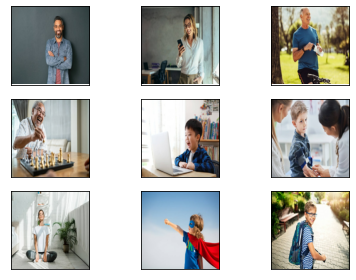

In [ ]:
i = 1
hold_image, _ = next(iter(train))
for image, label in train:
    ax = plt.subplot(3,3,i)
    plt.imshow(image)
    plt.yticks([])
    plt.xticks([])
        
    if i == 9:
        break
    i += 1

plt.tight_layout()

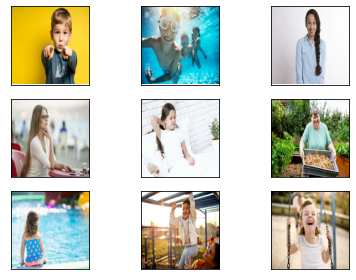

In [ ]:
i = 1
for image, label in test:
    ax = plt.subplot(3,3,i)
    plt.imshow(image)
    plt.yticks([])
    plt.xticks([])
        
    if i == 9:
        break
    i += 1

plt.tight_layout()

In [ ]:
class CNNBlock(layers.Layer):
    def __init__(self,channels_out,filter_size = 3):
        super(CNNBlock,self).__init__()
        
        self.conv = layers.Conv2D(channels_out,filter_size,padding = 'same')
        self.bn = layers.BatchNormalization()
    
    def call(self,input_tensor,training = False):
        
        x = self.conv(input_tensor)
        x = self.bn(x,training = training)
        x = tf.nn.relu(x)
        return x

class DenseBlock(layers.Layer):
    def __init__(self,units, dropout = 0.3):
      super(DenseBlock,self).__init__()

      self.dense = layers.Dense(units)
      self.relu = layers.ReLU()
      self.bn = layers.BatchNormalization()
      self.dropout = layers.Dropout(0.3)
    
    def call(self,input_tensor,training = False):

      x = self.dense(input_tensor)
      x = self.bn(x, training = training)
      x = self.relu(x)
      return self.dropout(x)

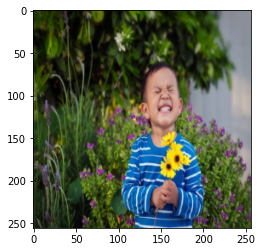

In [ ]:
plt.imshow(hold_image)
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(factor = 0.2),
  layers.RandomRotation(0.2),
  layers.RandomFlip('horizontal_and_vertical')
  ])

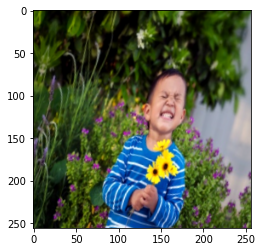

In [ ]:
image = data_augmentation(hold_image)
plt.imshow(image)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train = train.cache()
train = train.shuffle(num_train)
train = train.batch(32)
train = train.prefetch(AUTOTUNE)

test = test.batch(32)
test = test.prefetch(AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    CNNBlock(64,3),
    layers.MaxPooling2D(2),
    CNNBlock(128,3),
    layers.MaxPooling2D(2),
    CNNBlock(256,3),
    layers.Flatten(),
    DenseBlock(256),
    DenseBlock(128),
    DenseBlock(64),
    layers.Dense(1, activation = 'sigmoid')
])



In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='max',verbose=1,min_lr=0.001,factor=0.1)
model_checkpoint = keras.callbacks.ModelCheckpoint('checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=90)

model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate = 1e-03),
              metrics = ['accuracy']
             )

In [ ]:
model.fit(train,epochs = 100, batch_size = 32, validation_data = (test))

Epoch 1/100


22/22 [==============================] - ETA: 0s - loss: 0.7503 - accuracy: 0.5426

22/22 [==============================] - 13s 310ms/step - loss: 0.7503 - accuracy: 0.5426 - val_loss: 0.7413 - val_accuracy: 0.5083
Epoch 2/100
22/22 [==============================] - 6s 265ms/step - loss: 0.7277 - accuracy: 0.5765 - val_loss: 0.6900 - val_accuracy: 0.4333
Epoch 3/100
22/22 [==============================] - 6s 254ms/step - loss: 0.6964 - accuracy: 0.5956 - val_loss: 0.6948 - val_accuracy: 0.5417
Epoch 4/100
22/22 [==============================] - 6s 260ms/step - loss: 0.6991 - accuracy: 0.5941 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/100
22/22 [==============================] - 6s 256ms/step - loss: 0.6789 - accuracy: 0.6147 - val_loss: 0.6718 - val_accuracy: 0.5667
Epoch 6/100
22/22 [==============================] - 6s 257ms/step - loss: 0.6691 - accuracy: 0.6176 - val_loss: 0.6621 - val_accuracy: 0.5833
Epoch 7/100
22/22 [==============================] - 6s 265ms/step - loss: 0.6776 - accuracy: 0.6029 - val_loss: 0.6647 - val_accuracy: 0.6000
Epoch 8/10